In [1]:
import cv2
from PIL import Image
import pytesseract
import matplotlib as plt

# Image Preprocessing

## Opening an Image

In [4]:
image_file = "dataset/IMG-20211108-WA0016.jpg"
img = cv2.imread(image_file)

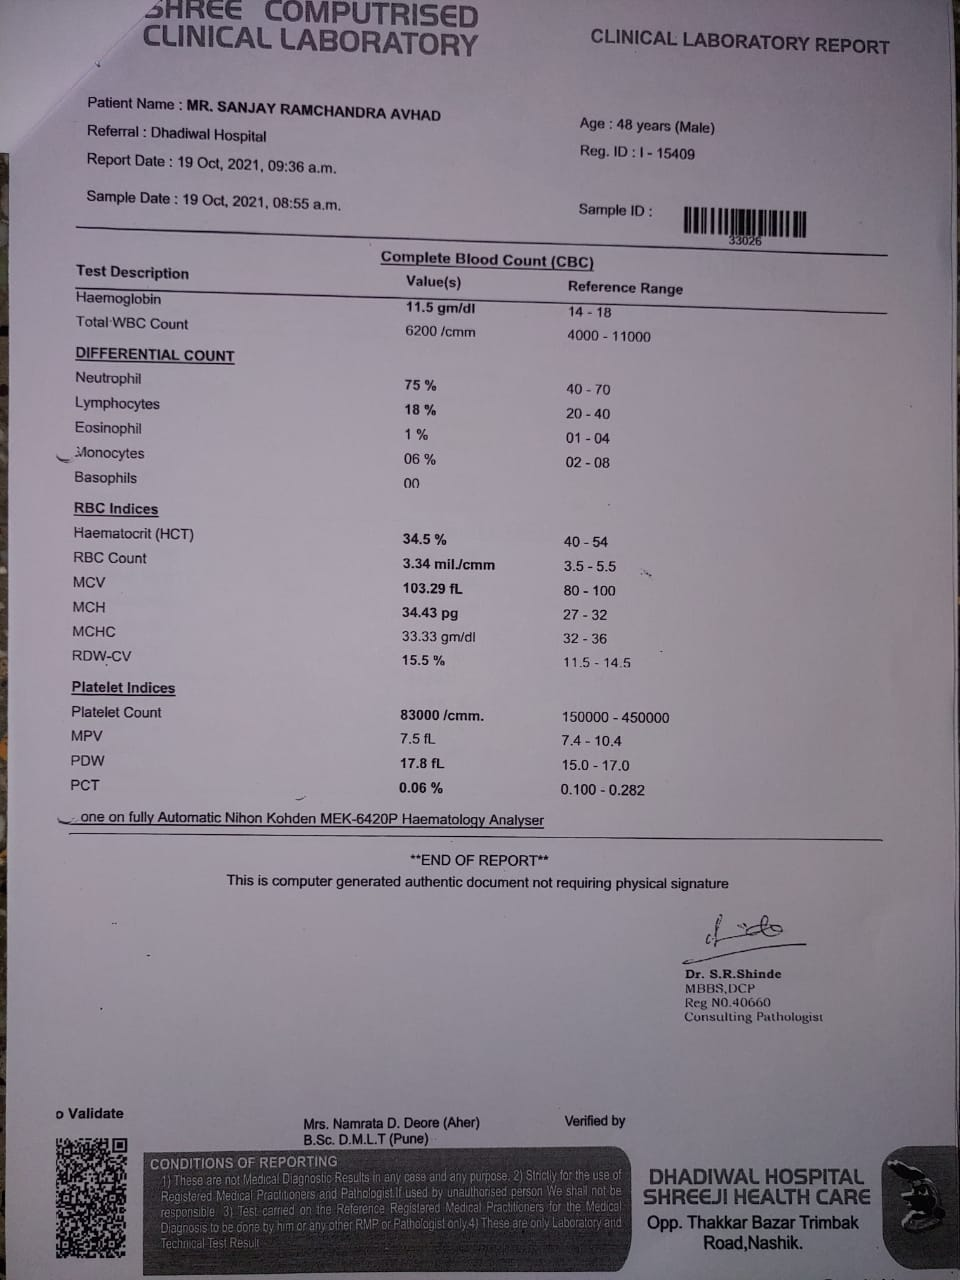

In [5]:
from IPython.display import Image
Image(filename=image_file) 

## Inverting

In [6]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("temp/inverted.jpg", inverted_image)

True

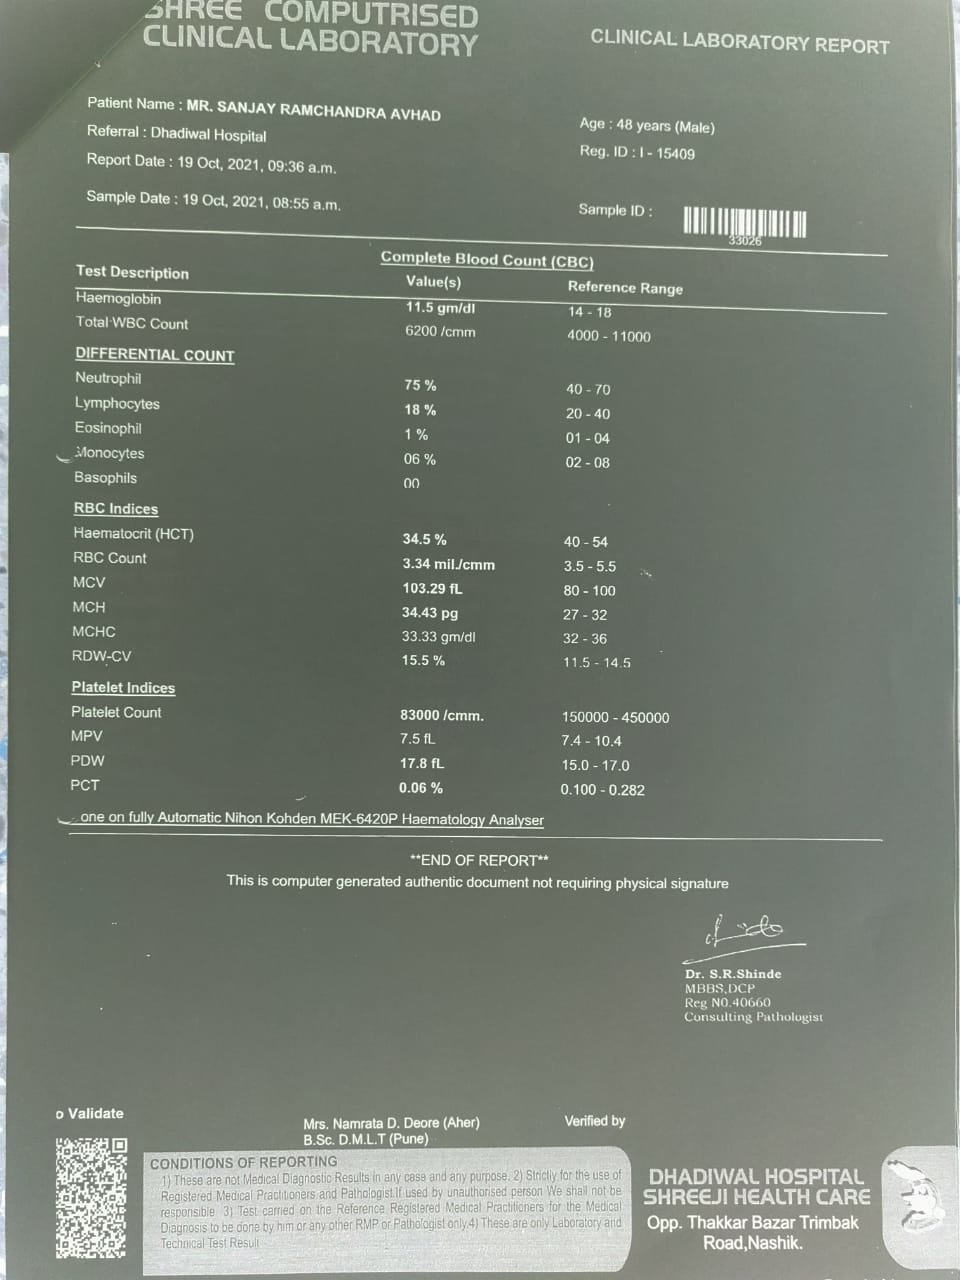

In [8]:
Image(filename="temp/inverted.jpg")

## Binarization

In [9]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
gray_image = grayscale(img)
cv2.imwrite("temp/gray.jpg", gray_image)

True

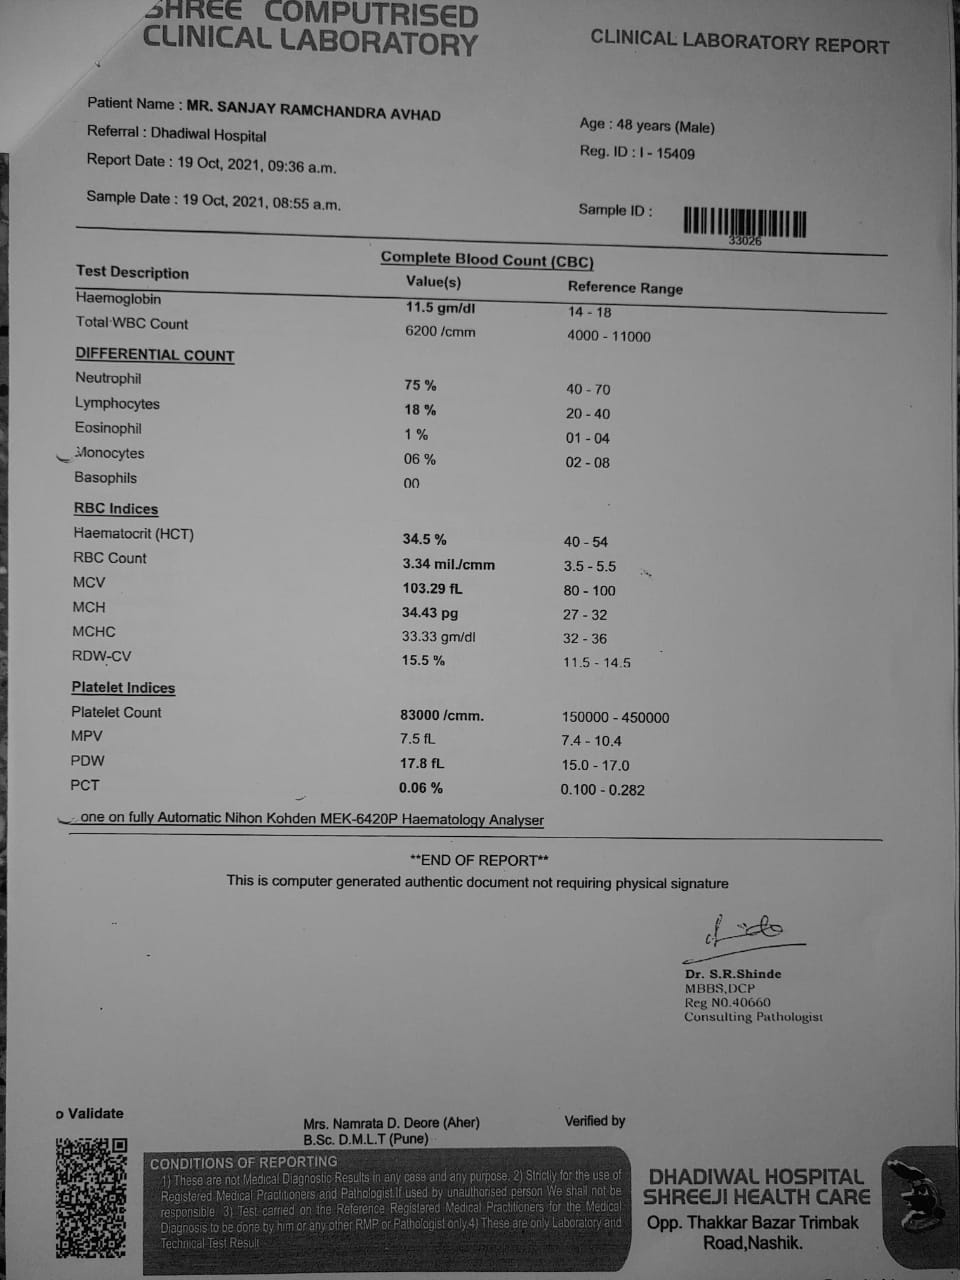

In [11]:
Image(filename="temp/gray.jpg")

In [96]:
thresh, im_bw = cv2.threshold(gray_image, 97, 230, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image.jpg", im_bw)

True

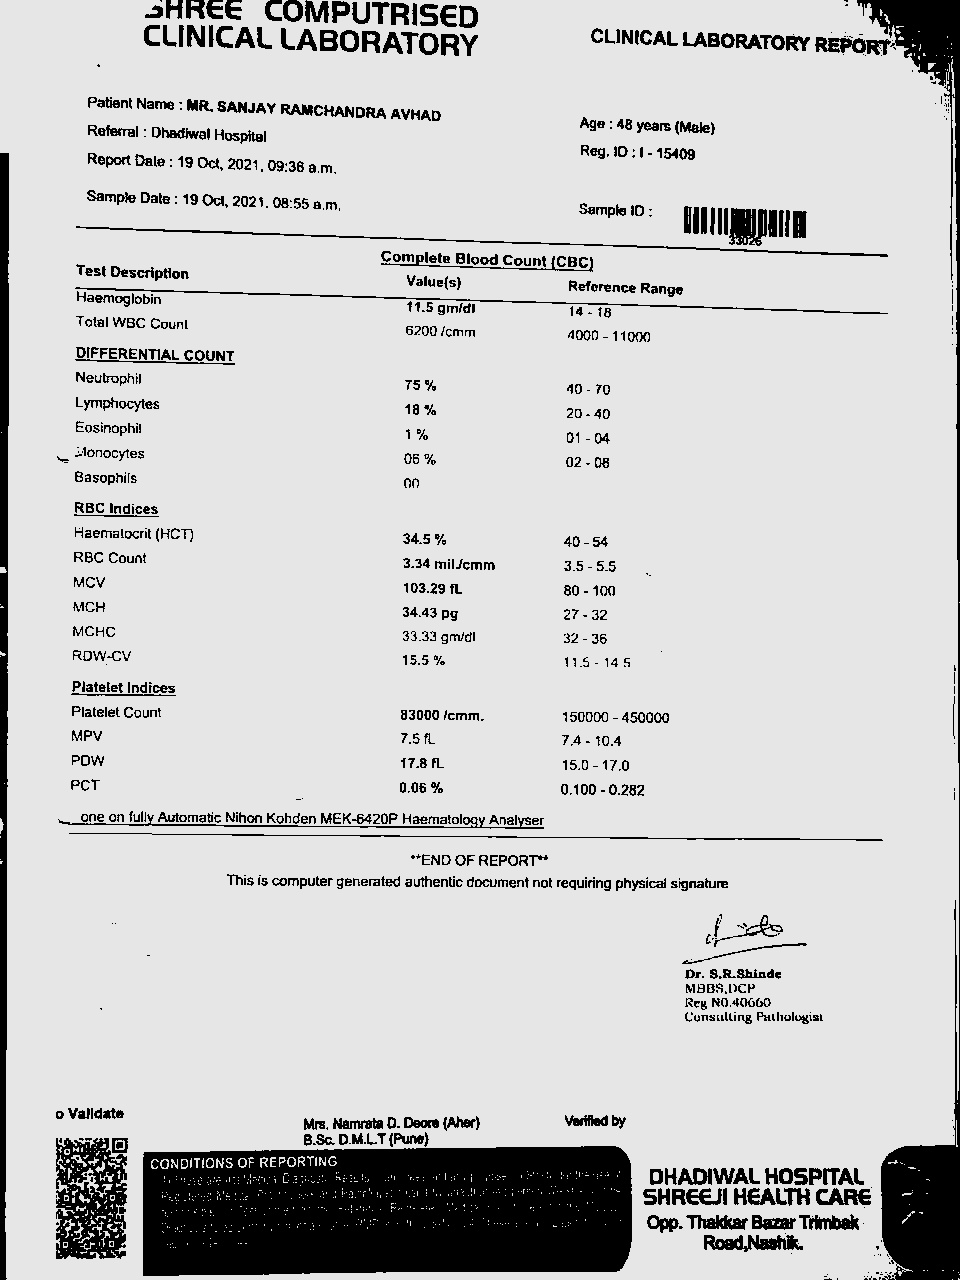

In [97]:
Image(filename="temp/bw_image.jpg")

## Noise Removal

In [110]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [111]:
no_noise = noise_removal(im_bw)
cv2.imwrite("temp/no_noise.jpg", no_noise)

True

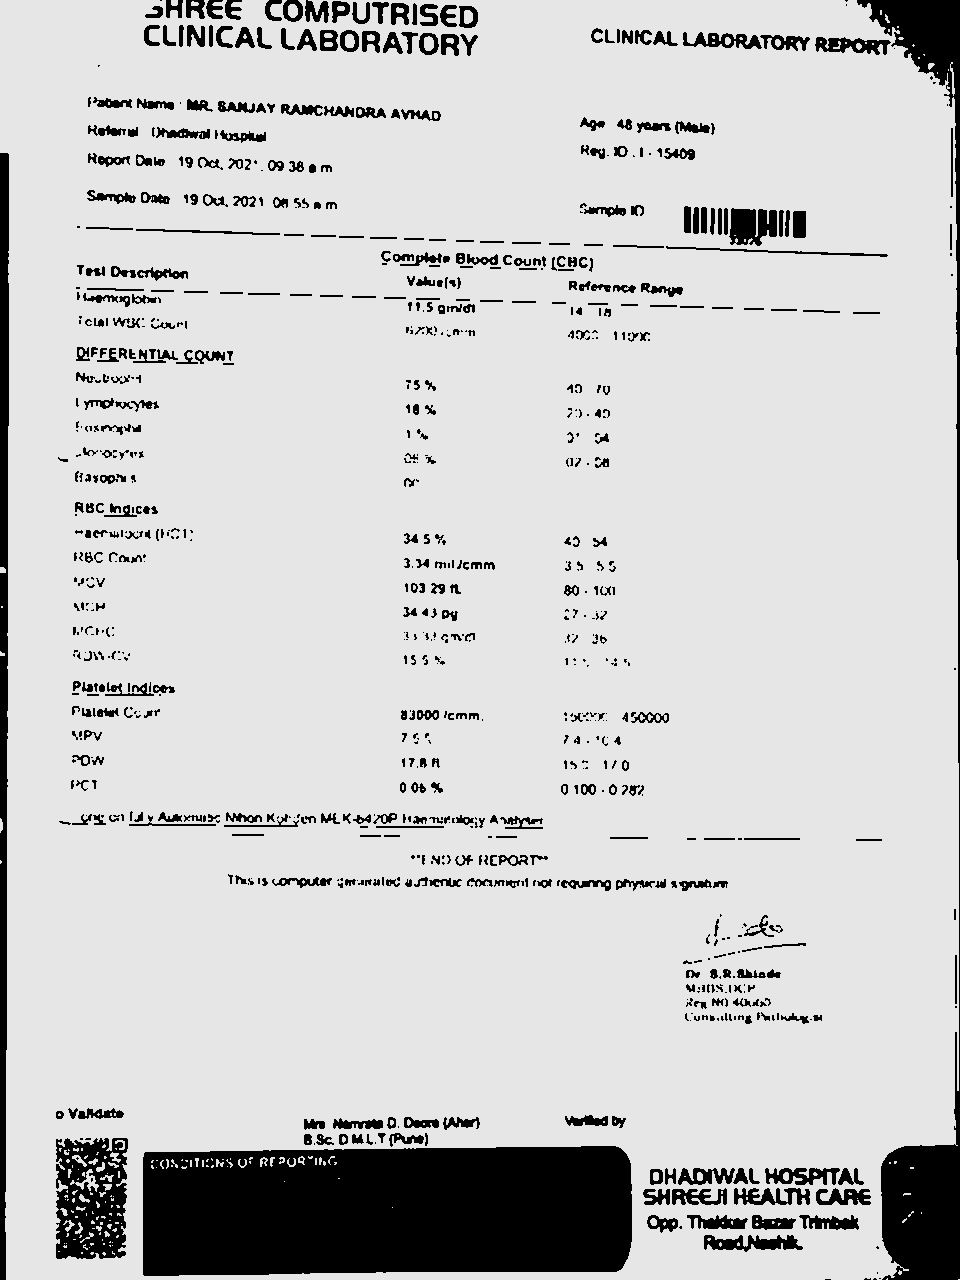

In [112]:
Image(filename="temp/no_noise.jpg")

## Dilation and Erosion

In [130]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((1,1),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image= cv2.bitwise_not(image)
    return image

In [131]:
eroded_image = thin_font(no_noise)
cv2.imwrite("temp/eroded_image.jpg", eroded_image)

True

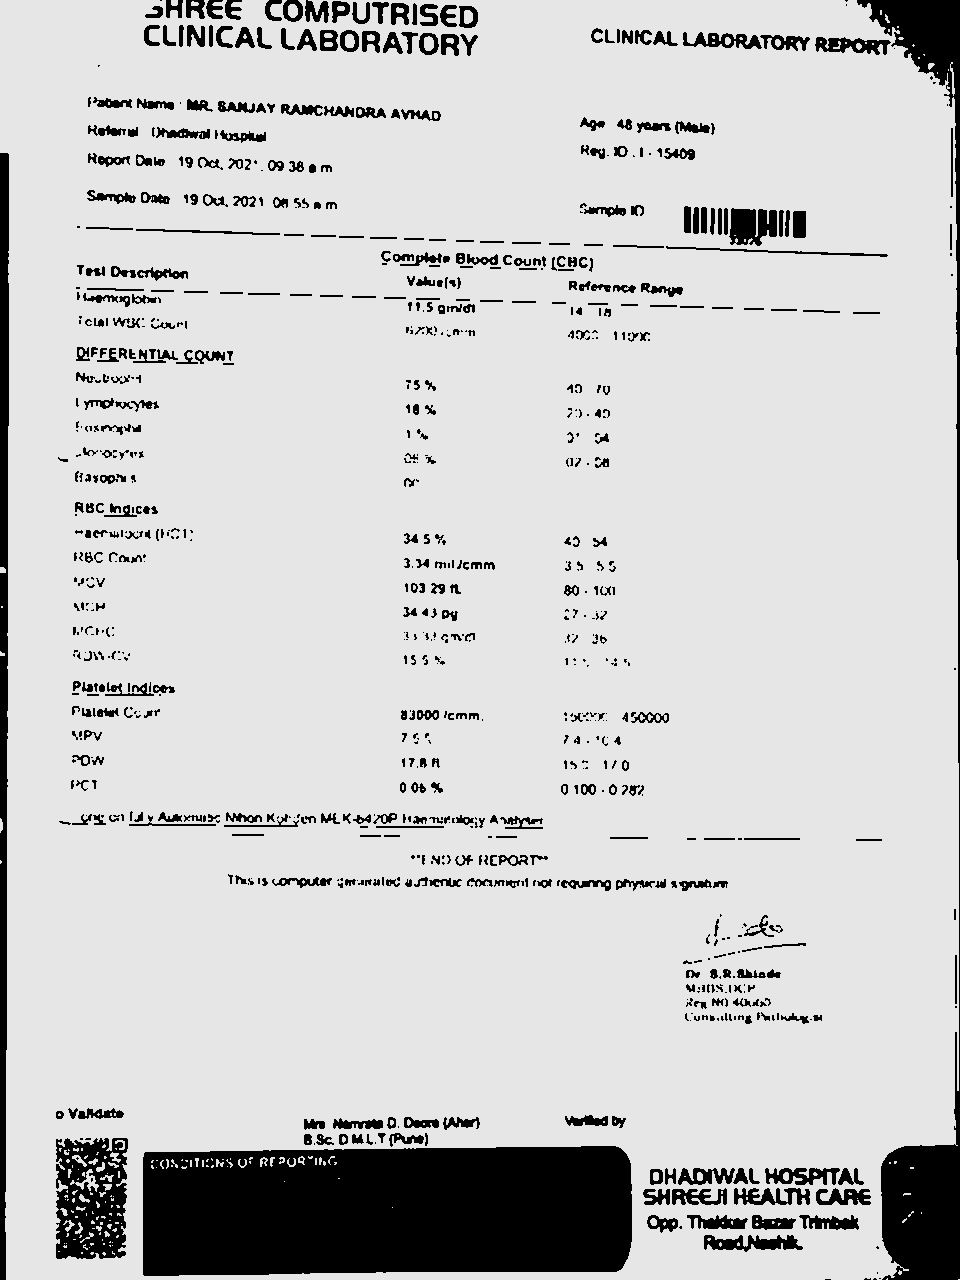

In [132]:
Image(filename="temp/eroded_image.jpg")

In [157]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image= cv2.bitwise_not(image)
    return image

In [158]:
dilated_image = thick_font(im_bw)
cv2.imwrite("temp/dilated_image.jpg", dilated_image)

True

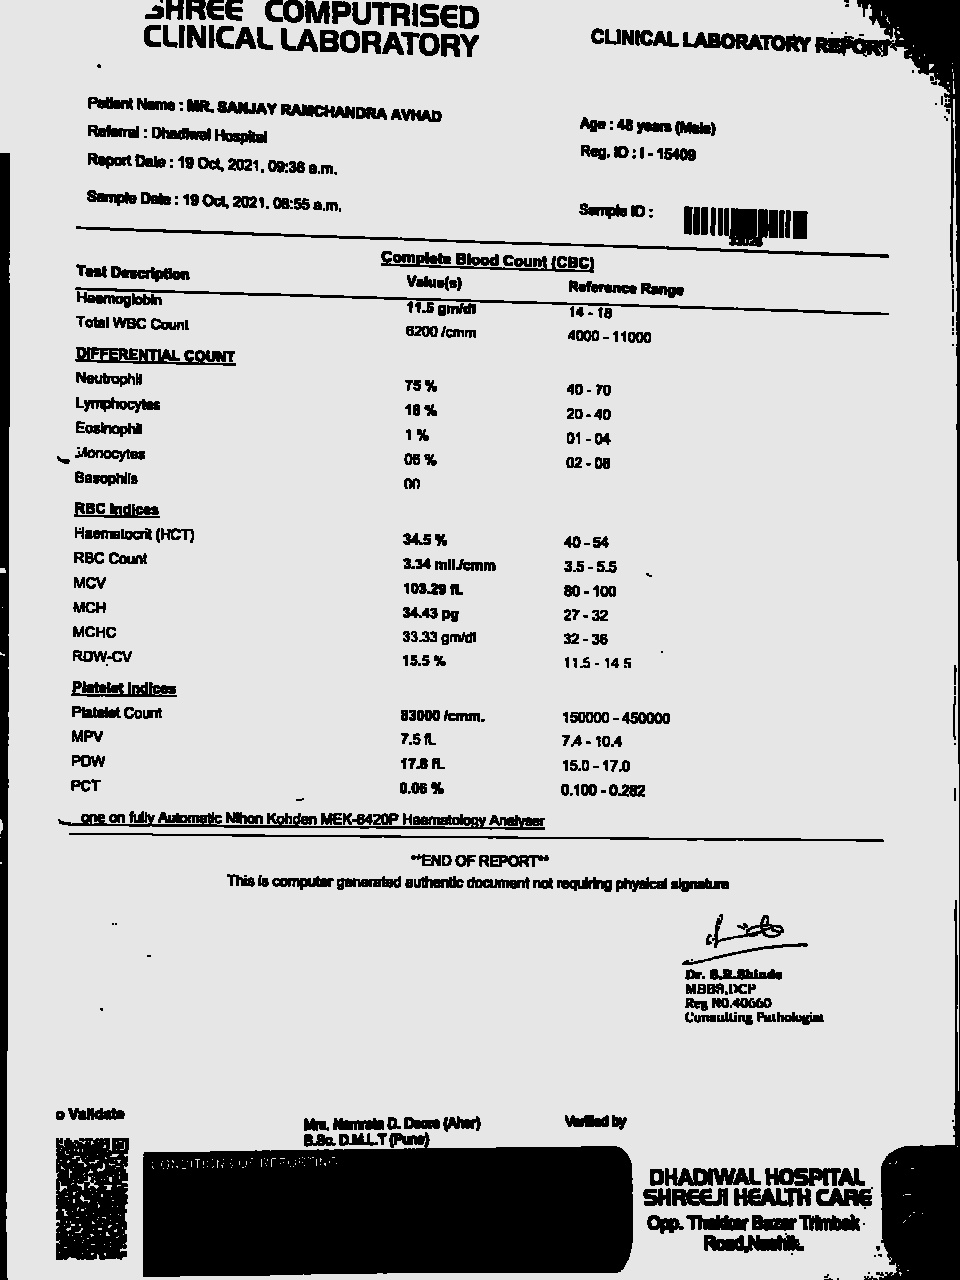

In [159]:
Image(filename="temp/dilated_image.jpg")

## Rotation / Deskewing

In [170]:
 #https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [171]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [175]:
fixed = deskew(img)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

77


True

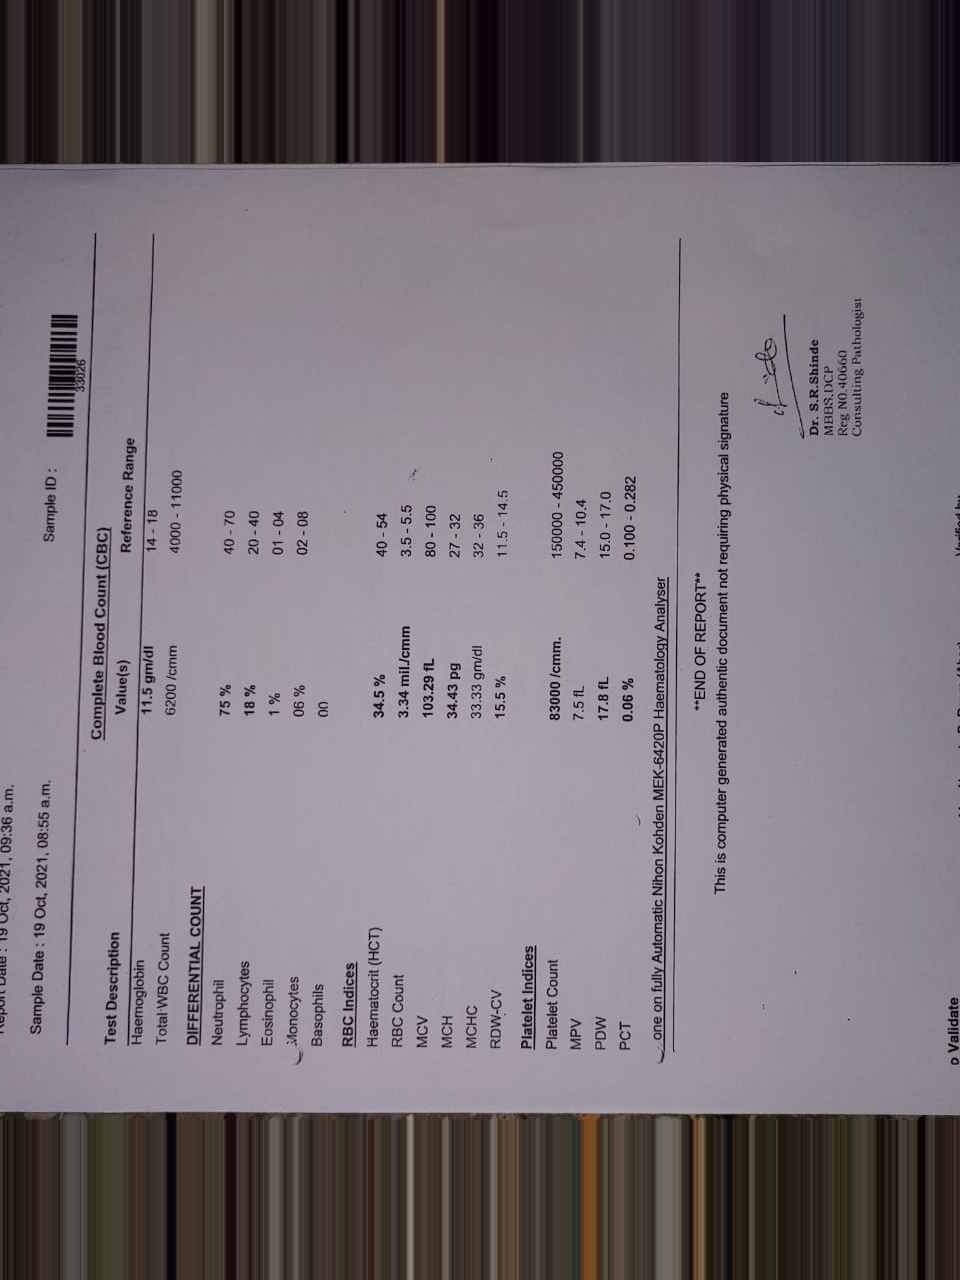

In [176]:
Image(filename="temp/rotated_fixed.jpg")

## Removing Borders

In [164]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

In [165]:
no_borders = remove_borders(im_bw)
cv2.imwrite("temp/no_borders.jpg", no_borders)

True

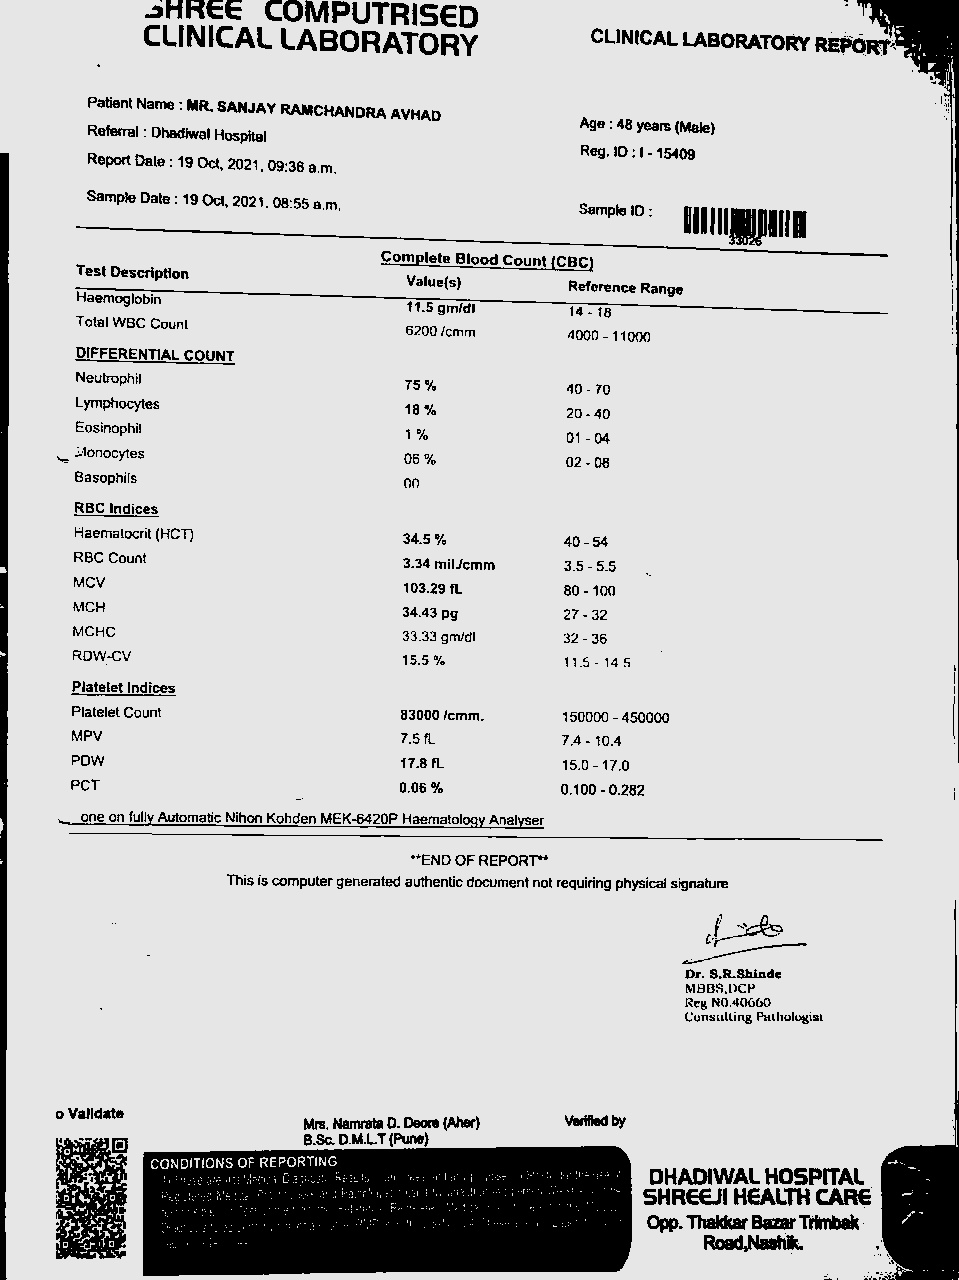

In [166]:
Image(filename="temp/no_borders.jpg")

In [183]:
img_no_borders = cv2.imread("temp/no_borders.jpg")

In [184]:
fixed = deskew(img_no_borders)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

73


True

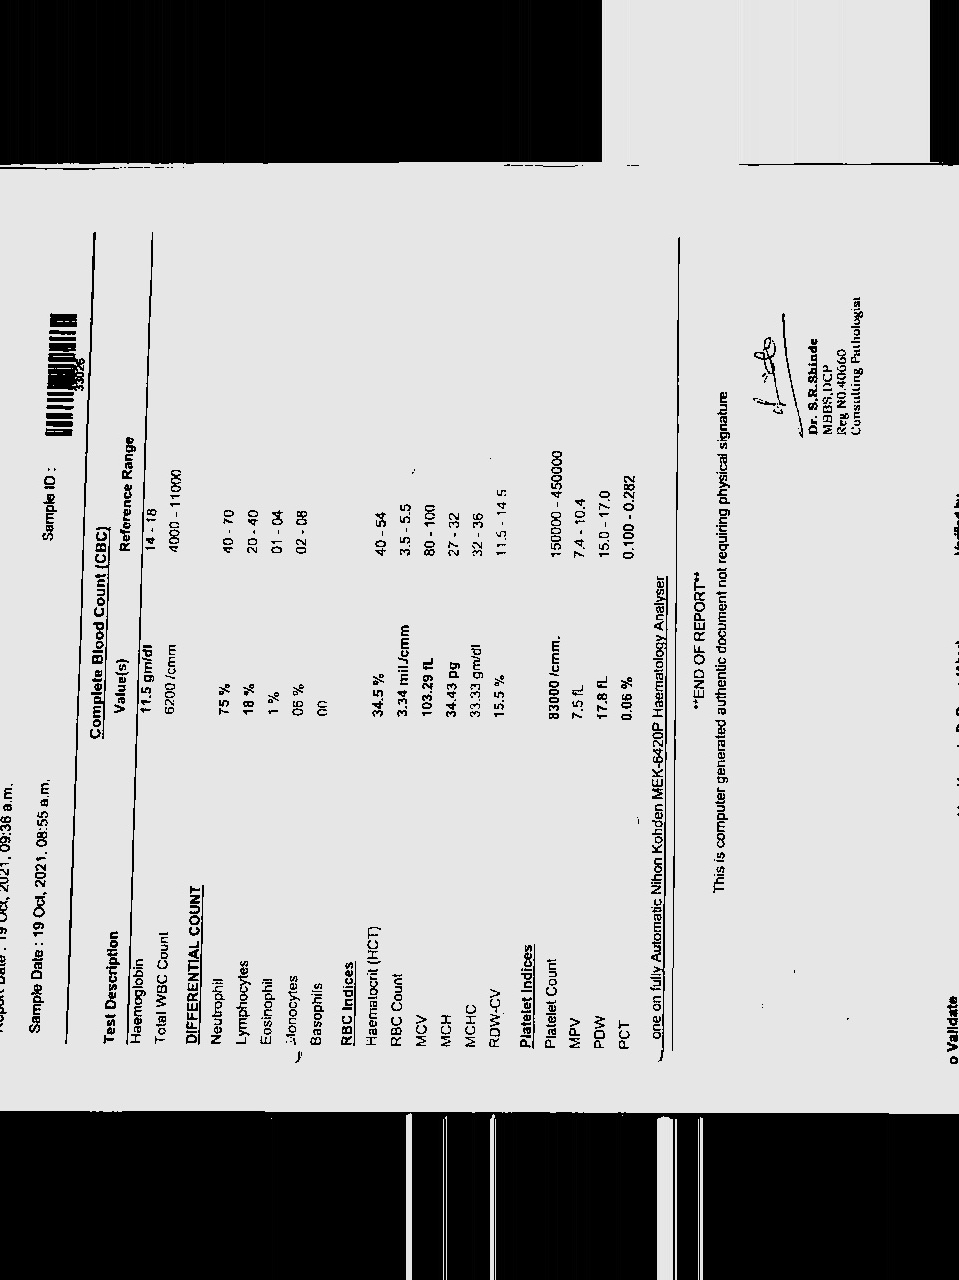

In [185]:
Image(filename="temp/rotated_fixed.jpg")

## Missing Borders

In [186]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

In [187]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("temp/image_with_border.jpg", image_with_border)
display("temp/image_with_border.jpg")

'temp/image_with_border.jpg'

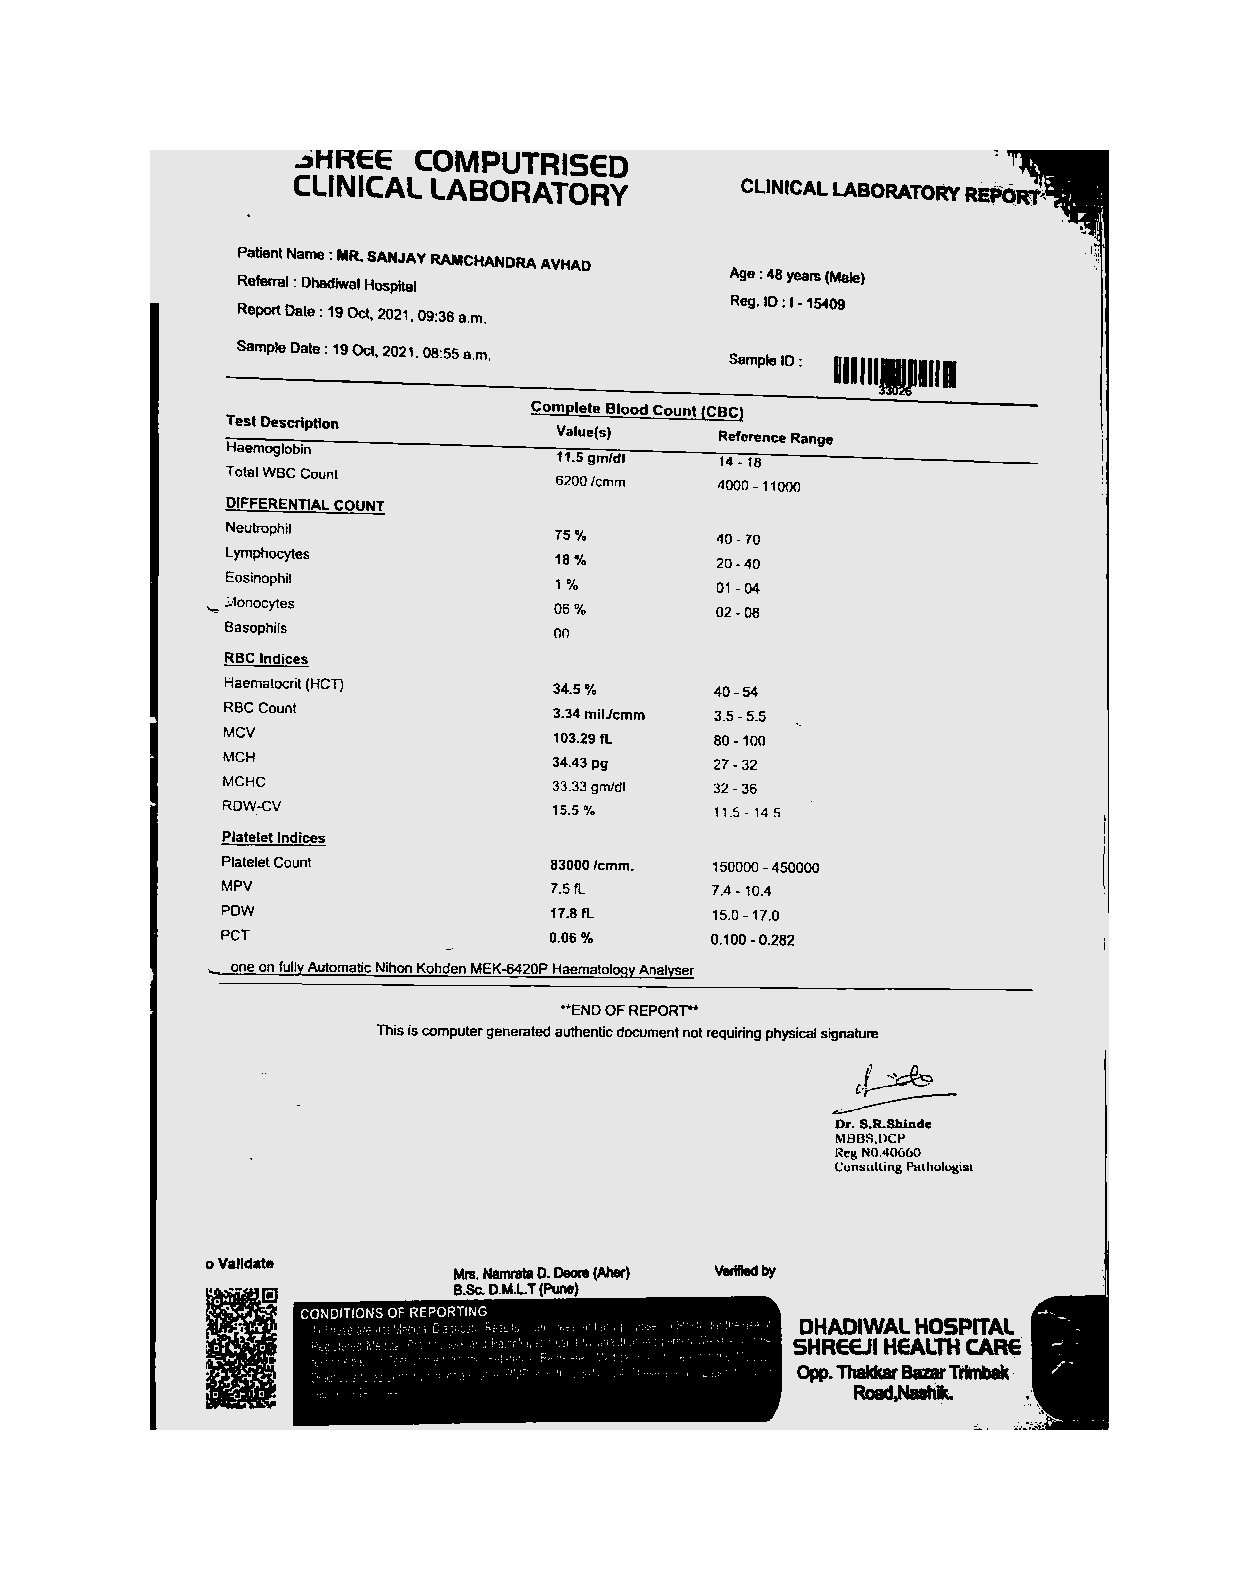

In [188]:
Image(filename="temp/image_with_border.jpg")

In [189]:
img_with_borders = cv2.imread("temp/image_with_border.jpg")

In [190]:
fixed = deskew(img_with_borders)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

71


True

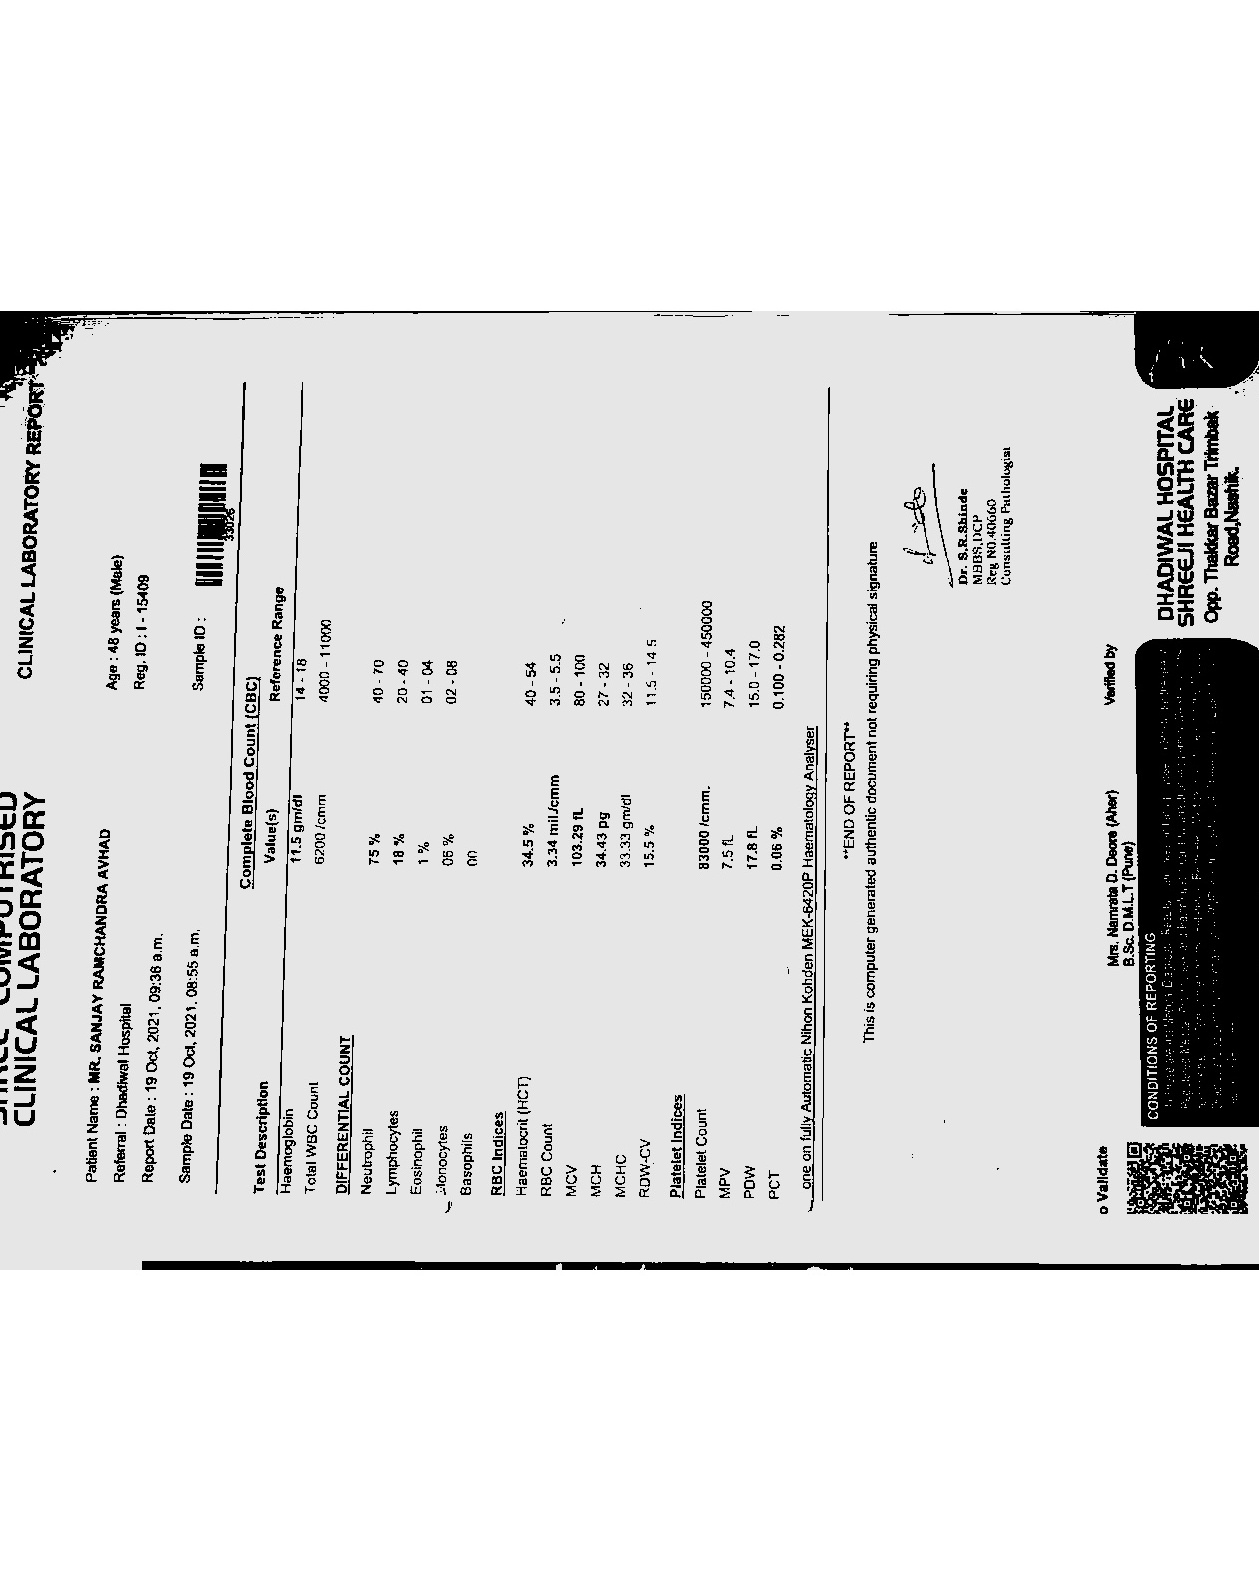

In [191]:
Image(filename="temp/rotated_fixed.jpg")

In [192]:
import pytesseract
from PIL import Image

In [194]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # your path may be different

In [199]:
ocr_result = pytesseract.image_to_string(img)

In [200]:
print(ocr_result)

2nnce COMPUTRISED
CLINICAL LABORATORY

Pationt Name : MR. SANJAY RAMCHANDRA AVHAD

Referral : Dhadiwal Hospital
Report Date : 19 Oct, 2021, 09:36 a.m.

‘Sample Date : 19 Oct, 2021, 08:55 a.m,

CLINICAL LABORATORY REPORT “

‘Age : 48 years (Male)
Reg. ID :1- 15409

Sever OMNIA

Complete Blood Count (CBC}

Test Description Value(s) Reference Range
Haemoglobin 11.5 amid 4-16
Total WBC Count 6200 /emm 4000 - 14000
DIFFERENTIAL COUNT
Neutrophil 75% 40-70
Lymphocytes 18% 20-40
Eosinophil 1% 01-04

— Monocytes 06 % 02-08
Basophils 00
RBC Indices
Haematocrit (HCT) 34.5% 40-54
RBC Count 3.34 miliemm 35-55
Mcv 103.29 fL 80 - 100
MCH 34.43 pg 27-32
MCHC 33.33 gil 32-36
ROW-cv 15.5% 115-145
Platelet indices
Platelet Count 83000 /cmm. 150000 - 450000
MPV 75 i 74-104
PDW 17.8 fL 15.0-17.0
PCT 0.06 % 0.100 - 0.282

‘one on fully Automatic Nihon Kohden MEK-6420P Haematology Analyser

This is computer generated authentic document not requiring physical signature

CONDITIONS OF REPORTING
1 re not Medica

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)